# Segmentation - Mini Project

Created by:

Tomislav Tomov 6003618

Ioana Stoicescu 6003487

## Introduction

Now it's your turn to put it all together and train a segmentation model on a new dataset. The dataset is called ‘Cityscapes Dataset’ and contains a series of stereo video sequences recorded in street scenes from 50 different cities [see official Website](https://www.cityscapes-dataset.com/). 
However, we will use a modified version of this dataset as the original dataset may be too large for this project. The modified version only contains images of 10 cities. Of course, we have kept the images from **Ulm**. You may remember where some of the scenes were taken<br>

**Some Hints:**

- When you import the data, you probably want to use the masks with the extension 'instanceIds.png'. These masks contain the class IDs. [This script](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) contains the mapping between class IDs and class names. <br>
- Also as you can see in the script the dataset defines 34 different classes. However, you may want to reduce the number of classes to achieve reasonable results. You can do this by merging classes together. E.g. instead of using the raw class ids, you could use the class categories 'void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle'. <br> 

<br>
The data set is located under `/data/cityscapes`.
Feel free to follow the CRISP-DM framework to structure your work. <br>
Overall you should work through the following steps:
- 1. Data Understanding and Data Preparation
- 2. Modelling and Training
- 3. Evaluation
- 4. Dilated Convolutions
- 5. Further Architectures

Use this notebook as a starting point and make sure to explain your steps and discuss your results. The goal is not to get the best possible results but to create a well structured data science story. But of course, if you get good results, that´s great! <br>
Feel free to reuse code from the lecture notebooks if you find it useful. <br>

NameError: name 'nvcc' is not defined

In [177]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import os
import time
print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
use_cuda = cuda_available

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# helper function to count number of parameters in a model
def count_parameters(model):
    params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    m_params = params / 1e6
    print(f"Model has {m_params:.2f}M parameters")


2.5.0+cpu
cuda available: False


# 1. Data Understanding and Data Preparation
Your task now is to load the data and gain an understanding of the data set. <br>
For this you have to perform the following steps:
1. Build a PyTorch Dataset to read in the data
2. Analyze the dataset by plotting some samples including the masks
3. Analyze the class distribution and the spatial distribution of the classes

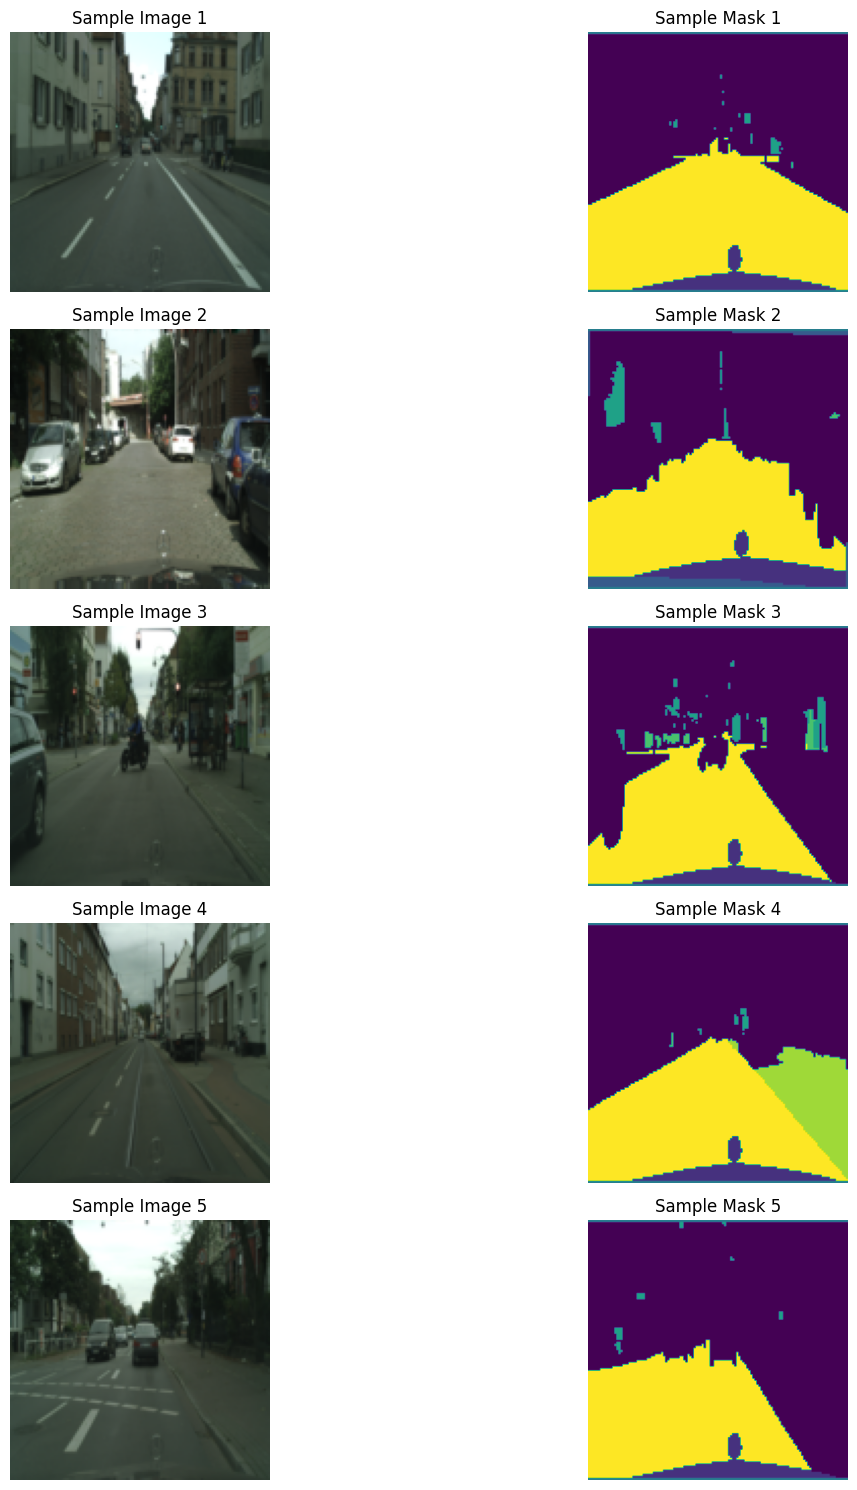

Calculating spatial heatmaps: 100%|███████████████████████████████████████████████| 1258/1258 [02:29<00:00,  8.43it/s]


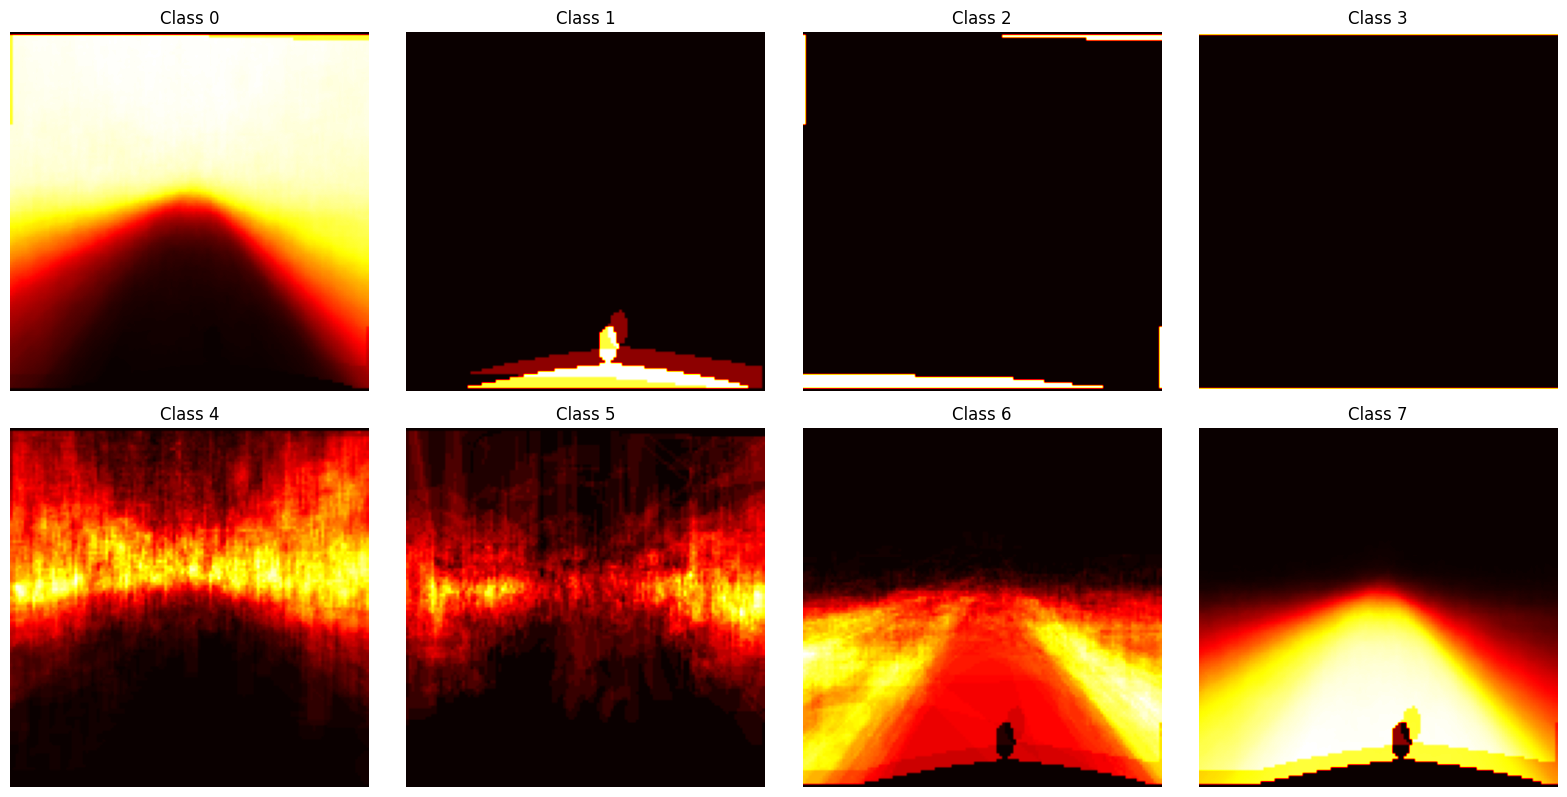

In [74]:
CLASS_MAPPING = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle'
}

SHAPE = (128, 128)

image_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MaskToTensor:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mask_values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 255])

    def __call__(self, mask):
        segmentation_mask = np.array(mask)
        one_hot_mask = torch.zeros_like(torch.tensor(segmentation_mask), dtype=torch.long)
        for i, value in enumerate(self.mask_values):
            one_hot_mask[segmentation_mask == value] = i
        return one_hot_mask

label_transform = transforms.Compose([
    transforms.Resize(SHAPE, interpolation=InterpolationMode.NEAREST_EXACT),
    MaskToTensor(len(CLASS_MAPPING))
])

class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', image_transform=None, label_transform=None):
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.label_transform = label_transform

        images_dir = os.path.join(root_dir, 'images', split)
        masks_dir = os.path.join(root_dir, 'masks', split)

        self.files = []
        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(masks_dir, os.path.relpath(root, images_dir), file.replace('_leftImg8bit.png', '_gtFine_labelIds.png'))
                    if os.path.exists(mask_path):
                        self.files.append((image_path, mask_path))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path, mask_path = self.files[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            mask = self.label_transform(mask)

        return image, mask


root_dir = "E:\\Facultate\\Jupyter_notebooks\\Homework\\data\\cityscapes"
train_dataset = CityscapesDataset(root_dir, split='train', image_transform=image_transform, label_transform=label_transform)
test_dataset = CityscapesDataset(root_dir, split='test', image_transform=image_transform, label_transform=label_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def debug_mask_alignment(dataset):
    for _, mask in dataset:
        unique_classes = torch.unique(mask)
        print(f"Unique classes in a mask: {unique_classes}")
        print(f"Expected classes: {list(CLASS_MAPPING.keys())}")
        break

def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        image = denormalize_image(image).permute(1, 2, 0).numpy() 
        image = np.clip(image, 0, 1) 
        
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(image)
        plt.title(f"Sample Image {i+1}")
        plt.axis('off')

        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(mask, cmap='viridis')
        plt.title(f"Sample Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_samples(train_dataset, num_samples=5)

def spatial_heatmaps(dataset, num_classes=len(CLASS_MAPPING), shape=SHAPE):
    heatmaps = np.zeros((num_classes, *shape), dtype=np.float32)
    for _, mask in tqdm(dataset, desc="Calculating spatial heatmaps"):
        mask = np.array(mask, dtype=np.int32)  # Ensure mask is a NumPy array
        for cls in range(num_classes):
            heatmaps[cls] += (mask == cls).astype(np.float32)
    return heatmaps
train_heatmaps = spatial_heatmaps(train_dataset)

def plot_spatial_heatmaps(heatmaps, class_names):
    plt.figure(figsize=(16, 16))
    num_classes = heatmaps.shape[0]
    for i in range(num_classes):
        plt.subplot(4, 4, i+1)
        plt.imshow(heatmaps[i], cmap='hot')
        plt.title(class_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

class_names = [f"Class {i}" for i in range(16)]
plot_spatial_heatmaps(train_heatmaps, class_names)



# 2. Modelling and Training
Next, your task is to train a segmentation model on the data set. You can start with the simplified U-network from the lecture. 
<br>
For this you have to perform the following steps:
1. Define the model
2. Define the loss function
3. Setup the training loop
4. Setup the optimizer
5. Train the model 
6. Visualize the training history



Using device: cpu
Epoch 1/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.17s/it]


Train Loss: 0.9470, Test Loss: 0.8750
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 2/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.14s/it]


Train Loss: 0.6058, Test Loss: 0.6763
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 3/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.14s/it]


Train Loss: 0.5019, Test Loss: 0.6553
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 4/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.17s/it]


Train Loss: 0.4720, Test Loss: 0.6167
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 5/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.16s/it]


Train Loss: 0.4443, Test Loss: 0.6122
Labels unique values: tensor([0, 1, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 6/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.16s/it]


Train Loss: 0.4343, Test Loss: 0.6314
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 7/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:46<00:00,  2.24s/it]


Train Loss: 0.4105, Test Loss: 0.5441
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 8/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:46<00:00,  2.21s/it]


Train Loss: 0.4038, Test Loss: 0.5811
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 9/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:46<00:00,  2.21s/it]


Train Loss: 0.3758, Test Loss: 0.5523
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])
Epoch 10/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:46<00:00,  2.19s/it]


Train Loss: 0.3665, Test Loss: 0.4923
Labels unique values: tensor([0, 1, 2, 3, 4, 5, 6, 7])
Outputs shape: torch.Size([16, 8, 128, 128]), Labels shape: torch.Size([16, 128, 128])


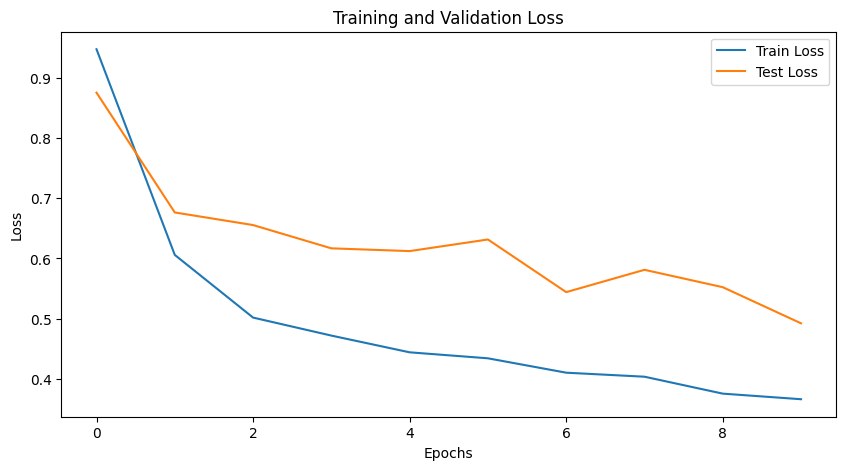

In [76]:
class DownLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x


class UpLayerInterpolate(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpLayerInterpolate, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        x = F.relu(x)
        return x


class UnetCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 64, 128], output_dim=len(CLASS_MAPPING)):
        super(UnetCNN, self).__init__()
        self.encoder_hidden_layers = nn.ModuleList()
        self.decoder_hidden_layers = nn.ModuleList()

        in_dim = input_dim
        for h_dim in hidden_dims:
            self.encoder_hidden_layers.append(DownLayer(in_dim, h_dim))
            in_dim = h_dim

        for h_dim in reversed(hidden_dims):
            self.decoder_hidden_layers.append(UpLayerInterpolate(in_dim + h_dim, h_dim))
            in_dim = h_dim

        self.output_layer = nn.Conv2d(in_dim, output_dim, kernel_size=1)

    def forward(self, x):
        encoder_outputs = []

        for layer in self.encoder_hidden_layers:
            x = layer(x)
            encoder_outputs.append(x)

        for i, layer in enumerate(self.decoder_hidden_layers):
            if i < len(encoder_outputs):
                x = torch.cat([x, encoder_outputs[-(i+1)]], dim=1)
            x = layer(x)

        x = self.output_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

criterion = nn.CrossEntropyLoss()

model = UnetCNN(hidden_dims=[32, 64, 128], output_dim=len(CLASS_MAPPING))
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).long()  
        labels = labels.squeeze(1) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).long() 
            labels = labels.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)

EPOCHS = 10
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
    test_loss = evaluate(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        print(f"Labels unique values: {torch.unique(labels)}")
        print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        break

def plot_training_history(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


plot_training_history(train_losses, test_losses)


# 3. Evaluation
Now your task is to evaluate the model on the test set. <br>
For this you have to perform the following steps:
1. Evaluate the model on the test set using the accuracy and the mean IoU
2. Visualize some predictions
3. Interpret the results

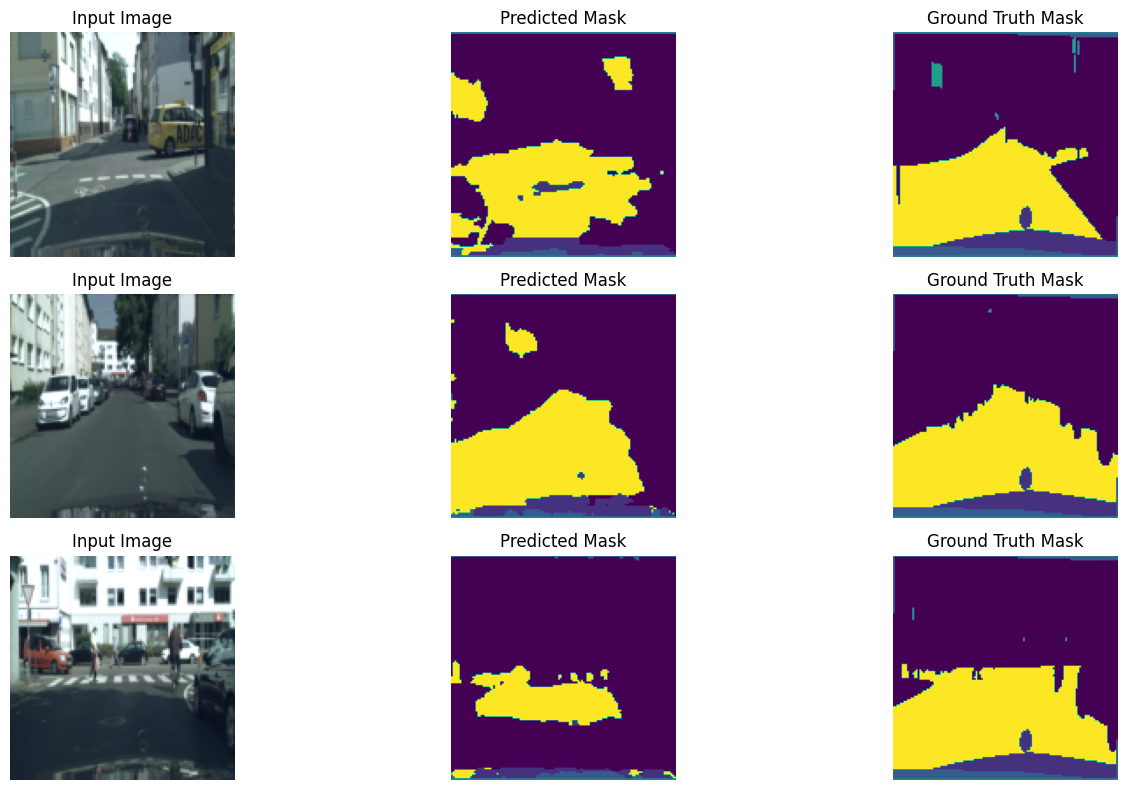

In [84]:
from sklearn.metrics import jaccard_score

def pixel_accuracy(outputs, labels):
    """Calculate pixel-wise accuracy."""
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def mean_iou(outputs, labels, num_classes):
    """Calculate mean Intersection over Union (IoU)."""
    _, preds = torch.max(outputs, dim=1)
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(preds == cls, labels == cls).sum()
        union = np.logical_or(preds == cls, labels == cls).sum()
        if union == 0:
            iou_per_class.append(float('nan')) 
        else:
            iou_per_class.append(intersection / union)
    return np.nanmean(iou_per_class)  

def evaluate_model_on_test(model, test_loader, device, num_classes):
    model.eval()
    total_accuracy = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1)
            outputs = model(images)
            total_accuracy += pixel_accuracy(outputs, labels)
            total_iou += mean_iou(outputs, labels, num_classes)
            count += 1

    avg_accuracy = total_accuracy / count
    avg_iou = total_iou / count
    return avg_accuracy, avg_iou

def visualize_predictions(model, test_loader, device, class_mapping):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1).cpu().numpy()
    labels = labels.squeeze(1).cpu().numpy()  

    plt.figure(figsize=(15, 8))
    for i in range(min(3, len(images))): 
        # Input image
        plt.subplot(3, 3, i * 3 + 1)
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = np.clip((image * 0.229 + 0.485), 0, 1)  
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")

        # Predicted mask
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(preds[i], cmap="viridis")
        plt.title("Predicted Mask")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(labels[i], cmap="viridis")
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device, CLASS_MAPPING)



#### Results interpretation
###### We can observe that the model is producing segmentation marks but has some limitations with class boundaries and some details.
###### Although some classes are identified correctly, predictions are not great.
###### Next step would be maybe to train more epochs and to increase input resolution.


# 4. Dilated Convolutions
Until now you should have used CNNs for several tasks. Starting with classification and now with segmentation. However, we have only used standard convolutions. Another powerful concept are dilated convolutions. They allow to increase the receptive field by using a dilated kernel. <br>
They were first introduced in a paper called "Multi-Scale Context Aggregation by Dilated Convolutions" [(Source)](https://arxiv.org/pdf/1511.07122) <br>
However, besides this scientific paper, there exists also severall nice explanations online you can find by searching for "dilated convolution"

<div style="color:blue">
Your task is now to look up and to understand the concept of dilated convolutions, and give a explanation here. Of course it is nice if you also try to visualize it.
</div>

##### Similar to gliding over an image, a kernel might be slid to discover patterns (edges or other textures) in it, as it slides across the surface of an image like a tiny stencil. Then, the local information would be condensed into a single representative version. With the introduction of space in between the stencil pieces, dilated convolutions enable the model to learn the bigger pattern without stretching the size of the stencil itself.

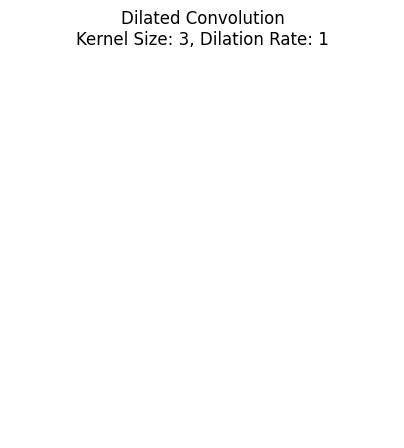

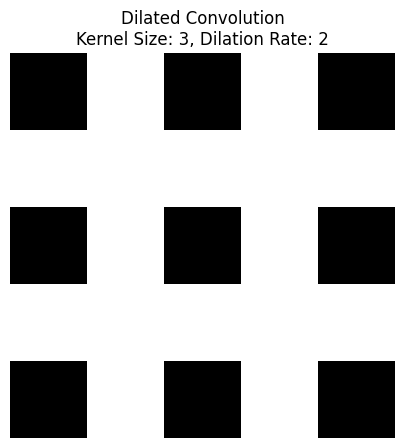

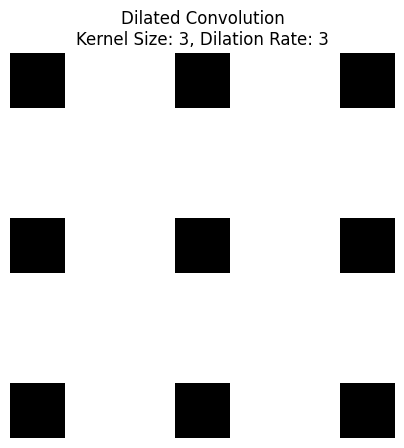

In [93]:
def visualize_dilated_kernel(kernel_size=3, dilation_rate=1):
    grid_size = kernel_size + (kernel_size - 1) * (dilation_rate - 1)
    grid = np.zeros((grid_size, grid_size))
    
    for i in range(0, grid_size, dilation_rate):
        for j in range(0, grid_size, dilation_rate):
            grid[i, j] = 1
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="Greys")
    plt.title(f"Dilated Convolution\nKernel Size: {kernel_size}, Dilation Rate: {dilation_rate}")
    plt.axis("off")
    plt.show()

# Visualize different dilation rates
visualize_dilated_kernel(kernel_size=3, dilation_rate=1)
visualize_dilated_kernel(kernel_size=3, dilation_rate=2)
visualize_dilated_kernel(kernel_size=3, dilation_rate=3)



Luckily in PyTorch there exists a ready to use implementation of dilated convolutions. Have a lock at the [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) documentation and try to understand how to use dilated convolutions/transposed convolutions in PyTorch. <br>
<div style="color:blue">
you are now tasked to change the implementation of the 'DownLayer' and 'UpLayerTranspose' to also allow for dilated convolutions.<br>
You can now implement a 'DilatedUNet' model which uses dilated convolutions in the 'DownLayer' and 'UpLayerTranspose'. <br>
Ensure that the model outputs the same shape as the input image. If this is not the case, you may have to adjust the padding parameter.

<br>
Afterwards you can train the model and evaluate it also the cityscapes dataset. <br> Does it perform differently than the standard U-Net?
</div>


Using device: cpu
Epoch 1/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


Train Loss: 1.2517, Test Loss: 1.1075
Epoch 2/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.11s/it]


Train Loss: 0.8241, Test Loss: 0.8600
Epoch 3/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


Train Loss: 0.5464, Test Loss: 0.6849
Epoch 4/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:48<00:00,  2.32s/it]


Train Loss: 0.4502, Test Loss: 0.6082
Epoch 5/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.14s/it]


Train Loss: 0.4271, Test Loss: 0.6140
Epoch 6/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.11s/it]


Train Loss: 0.4077, Test Loss: 0.5652
Epoch 7/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:43<00:00,  2.09s/it]


Train Loss: 0.3924, Test Loss: 0.5697
Epoch 8/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.16s/it]


Train Loss: 0.3935, Test Loss: 0.5402
Epoch 9/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.11s/it]


Train Loss: 0.3854, Test Loss: 0.5838
Epoch 10/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


Train Loss: 0.3603, Test Loss: 0.5119


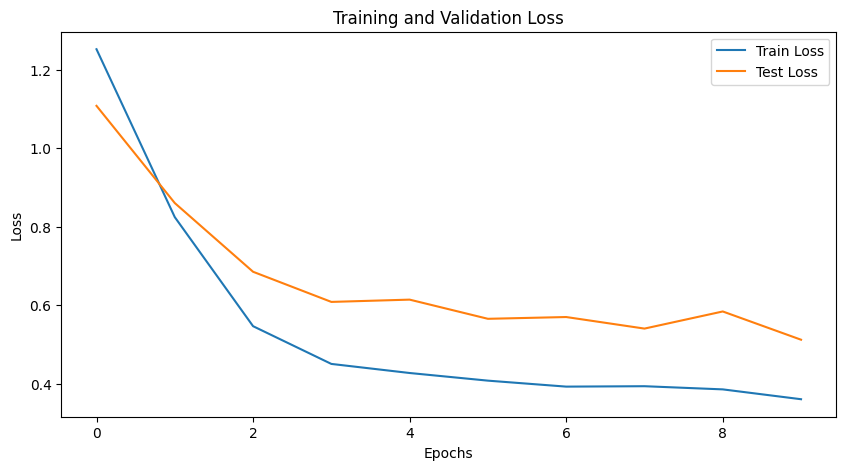

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


class DownLayerDilated(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=2):
        super(DownLayerDilated, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=2,
            padding=dilation,
            dilation=dilation,
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x


class UpLayerTransposeDilated(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0, dilation=1):
        super(UpLayerTransposeDilated, self).__init__()
        self.transposed_conv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.adjust_channels = nn.Conv2d(out_channels * 2, out_channels, kernel_size=1)
        self.refine = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip_connection):
        x = self.transposed_conv(x)
        if skip_connection is not None:
            if x.shape[2:] != skip_connection.shape[2:]:
                skip_connection = F.interpolate(skip_connection, size=x.shape[2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip_connection], dim=1) 
            x = self.adjust_channels(x) 
        x = self.refine(x) 
        x = F.relu(x)
        return x


class DilatedUNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 64, 128], output_dim=20):
        super(DilatedUNet, self).__init__()
        self.encoder_hidden_layers = nn.ModuleList()
        self.decoder_hidden_layers = nn.ModuleList()

        in_dim = input_dim
        for h_dim in hidden_dims:
            self.encoder_hidden_layers.append(DownLayerDilated(in_dim, h_dim, dilation=2))
            in_dim = h_dim

        for i, h_dim in enumerate(reversed(hidden_dims)):
            if i == 0:
                in_channels = h_dim
            else:
                in_channels = h_dim + hidden_dims[-(i + 1)] 
            self.decoder_hidden_layers.append(
                UpLayerTransposeDilated(in_channels, h_dim, kernel_size=2, stride=2, padding=0, dilation=1)
            )

        self.output_layer = nn.Conv2d(hidden_dims[0], output_dim, kernel_size=1)

    def forward(self, x):
        encoder_outputs = []

        for layer in self.encoder_hidden_layers:
            x = layer(x)
            encoder_outputs.append(x)

        for i, layer in enumerate(self.decoder_hidden_layers):
            skip_connection = encoder_outputs[-(i + 1)] if i < len(encoder_outputs) else None
            x = layer(x, skip_connection)

        x = self.output_layer(x)
        return x

def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).long()
        labels = labels.squeeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)


def evaluate(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).long()
            labels = labels.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)


def plot_training_history(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DilatedUNet(input_dim=3, hidden_dims=[32, 64, 128], output_dim=20)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
    test_loss = evaluate(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

plot_training_history(train_losses, test_losses)


#### DilatedUNet
##### It seems that dilated U-Net performed much better than standard U-Net.
##### test loss is also much much lower

# 5. Further Architectures
If you have time left and want to keep going, you can try to use more advanced architectures by using the [Pytorch Segmentation Models Package](https://github.com/qubvel-org/segmentation_models.pytorch) <br>
This package contains many state-of-the-art segmentation models. You can try to use one of them and train it on the dataset. <br>
If you have not installed the package yet, you can do it by running `!pip install segmentation_models_pytorch` <br>


In [171]:
import segmentation_models_pytorch as smp
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
# model Unet with ResNet backbone
model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",    
    in_channels=3,                
    classes=len(CLASS_MAPPING)    
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train_one_epoch_smp(model, optimizer, criterion, train_loader, device):
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device).long()
        labels = labels.squeeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate_smp(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device).long()
            labels = labels.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)

EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_one_epoch_smp(model, optimizer, criterion, train_loader, device)
    test_loss = evaluate_smp(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

plot_training_history(train_losses, test_losses)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\andre/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:03<00:00, 22.3MB/s]


Epoch 1/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [01:05<00:00,  3.12s/it]


Train Loss: 0.5909, Test Loss: 0.4675
Epoch 2/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [01:04<00:00,  3.06s/it]


Train Loss: 0.2779, Test Loss: 0.3835
Epoch 3/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:58<00:00,  2.78s/it]


Train Loss: 0.2383, Test Loss: 0.3977
Epoch 4/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [01:24<00:00,  4.02s/it]


Train Loss: 0.2198, Test Loss: 0.4379
Epoch 5/10


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:47<00:00,  2.27s/it]


Train Loss: 0.2099, Test Loss: 0.3082
Epoch 6/10


Training:   4%|██▋                                                                     | 3/79 [00:15<06:28,  5.11s/it]


KeyboardInterrupt: 